In [21]:
import numpy as np
import skfmm
from numpy import around, array, ma

def fmm_path_planning(obstacle_map, start, end):
    """
    Plans a path from start to end using the Fast Marching Method.

    Parameters:
    - obstacle_map: 2D numpy array where 0 is free space and 1 is occupied.
    - start: tuple (x, y) representing the starting position.
    - end: tuple (x, y) representing the ending position.

    Returns:
    - path: List of tuples [(x1, y1), (x2, y2), ..., (xn, yn)] representing the path.
    """
    obstacle_map = np.array(obstacle_map)
    # Swap x and y for indexing (row, col)
    start = (start[1], start[0])
    end = (end[1], end[0])

    # Check if start and end positions are valid
    if obstacle_map[start] == 1 or obstacle_map[end] == 1:
        print("Start or end position is inside an obstacle.")
        return None

    # Create a mask for obstacles
    traversible_ma = ma.masked_values(obstacle_map * 1, 1) 
    traversible_ma[obstacle_map==0] = 1
    traversible_ma[end] = 0

    # Compute the distance map using the signed distance function
    distance = skfmm.distance(traversible_ma, dx=1)
    distance = ma.filled(distance, np.max(distance) + 1)
    
    # return distance

    # Path initialization
    path = [start]
    current_pos = start
    max_iterations = obstacle_map.size  # To prevent infinite loops
    iteration = 0

    while current_pos != end and iteration < max_iterations:
        y, x = current_pos
        # Compute the gradient at the current position
        grad_y, grad_x = np.gradient(distance)
        grad = np.array([grad_y[y, x], grad_x[y, x]])
        if np.linalg.norm(grad) == 0:
            print("Zero gradient encountered; cannot proceed further.")
            return None
        # Move in the direction opposite to the gradient
        grad = -grad / np.linalg.norm(grad)
        # Compute the next position
        next_y = y + grad[0]
        next_x = x + grad[1]
        # Round to the nearest integer coordinates
        next_y = int(round(next_y))
        next_x = int(round(next_x))
        # Ensure the next position is within bounds
        if (0 <= next_y < obstacle_map.shape[0]) and (0 <= next_x < obstacle_map.shape[1]):
            # Check if the next position is free
            if obstacle_map[next_y, next_x] == 0:
                next_pos = (next_y, next_x)
            else:
                # Try neighboring positions in order of increasing distance from the gradient direction
                neighbors = []
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        if dy == 0 and dx == 0:
                            continue
                        ny, nx = y + dy, x + dx
                        if (0 <= ny < obstacle_map.shape[0]) and (0 <= nx < obstacle_map.shape[1]):
                            if obstacle_map[ny, nx] == 0:
                                distance_to_grad = np.hypot(grad[0] - dy, grad[1] - dx)
                                neighbors.append((distance_to_grad, (ny, nx)))
                if not neighbors:
                    print("No valid moves; path is blocked.")
                    return None
                # Select the neighbor closest to the gradient direction
                neighbors.sort()
                next_pos = neighbors[0][1]
        else:
            print("Next position is out of bounds.")
            return None

        if next_pos == current_pos:
            # No progress can be made
            print("Stuck at position", current_pos)
            return None
        current_pos = next_pos
        path.append(current_pos)
        iteration += 1

    if iteration >= max_iterations:
        print("Max iterations reached; no path found.")
        return None

    # Swap back the positions in the path to (x, y)
    path = [(p[1], p[0]) for p in path]
    return path



[(2, 2), (3, 3), (3, 4), (3, 5), (4, 6), (3, 6), (4, 7), (5, 8), (6, 8), (7, 8), (8, 8)]


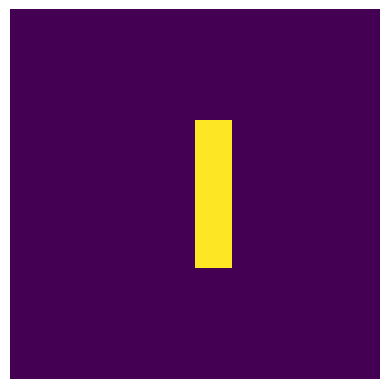

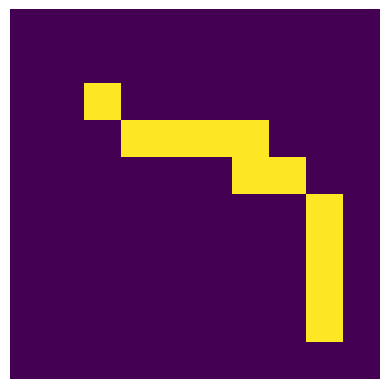

In [22]:
import cv2
import matplotlib.pyplot as plt

obstacle_map = np.zeros((10, 10))
obstacle_map[3:7, 5] = 1  # Add a vertical obstacle

# Start and end positions
start = (2, 2)  # (x1, y1)
end = (8, 8)    # (x2, y2)

# # Compute the path
path = fmm_path_planning(obstacle_map, start, end)
print(path)
x_indices, y_indices = zip(*path)
path_map = np.zeros(obstacle_map.shape)
path_map[x_indices, y_indices] = 1

plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(path_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()


# path_map = fmm_path_planning(obstacle_map, start, end)

# plt.imshow(path_map)
# plt.axis('off')  # 隐藏坐标轴
# plt.show()